In [2]:
# general
import numpy as np
from numpy.random import PCG64, SeedSequence
import pandas as pd
import verde as vd
import xarray as xr
import skgstat as skg
from skgstat import models
import gstatsim as gsm
from scipy.interpolate import RBFInterpolator
from scipy.stats import qmc
from sklearn.preprocessing import QuantileTransformer
from tqdm.auto import tqdm
import multiprocessing as mp

# plotting
import matplotlib.pyplot as plt

# io
from tqdm.auto import tqdm
import os
from pathlib import Path
import time
import numbers
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('..')

import gstatsim_custom as gsim

In [5]:
ds = xr.open_dataset(Path('../../bedmap/bedmap3_mod_1km.nc'))

# exposed_rock_cond = np.full(ds.thick_cond.shape, np.nan)
# exposed_rock_cond[ds.mask == 4] = True
thick_cond = np.where(ds.mask == 4, 0, ds.thick_cond.values)
#ground_ice_msk = ds.mask==1

bed_cond = ds.surface_topography.values - thick_cond
ice_rock_msk = (ds.mask == 1) | (ds.mask == 4) | (ds.mask == 2)
bed_cond = np.where(ice_rock_msk, bed_cond, np.nan)
xx, yy = np.meshgrid(ds.x, ds.y)

cond_msk = ~np.isnan(bed_cond)
#cond_msk = np.where(
x_cond = xx[cond_msk]
y_cond = yy[cond_msk]
data_cond = bed_cond[cond_msk]
trend = ds.trend.values

res_cond = bed_cond - trend

In [6]:
res_norm, nst_trans = gsim.utilities.gaussian_transformation(res_cond, cond_msk)
norm_values = res_norm[cond_msk==True]

rng = np.random.default_rng(0)

n_points = 2000

# randomly sample with latin hypercube sampling
bounds = [ds.x.values.min(), ds.y.values.min(), ds.x.values.max(), ds.y.values.max()]
l_bounds = bounds[:2]
u_bounds = bounds[2:]

sampler = qmc.LatinHypercube(d=2, optimization="lloyd", scramble=True, rng=rng)
sample = sampler.random(n=n_points)
points = qmc.scale(sample, l_bounds, u_bounds)

In [7]:
points[:5,:]

array([[ 1451709.93926116,  2374823.91650993],
       [  114961.67728724,   601577.94475463],
       [-1566596.88407216, -3210321.7688055 ],
       [ 2999218.00925142, -1713342.05142791],
       [ -888233.82995172,   774443.84168529]])

In [8]:
x_cond.size, y_cond.size, norm_values.size

(2386654, 2386654, 2386654)

In [9]:
np.count_nonzero(np.isnan(norm_values))

0

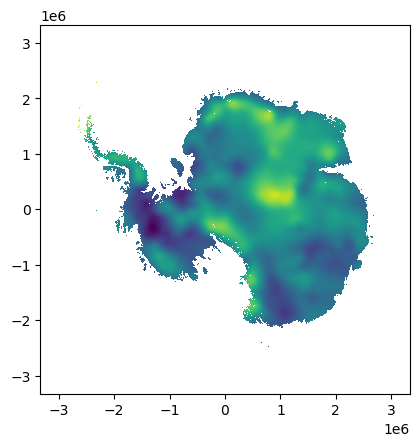

In [10]:
plt.pcolormesh(ds.x, ds.y, trend)
plt.axis('scaled')
plt.show()

In [11]:
ground_ice_rock_msk = (ds.mask==1) | (ds.mask==4)

good_points = np.full(points.shape[0], True)

for k, p in enumerate(points):
    i = np.argmin(np.abs(ds.y.values - p[1]))
    j = np.argmin(np.abs(ds.x.values - p[0]))
    if ground_ice_rock_msk[i, j] == False:
        good_points[k] = False

print(points.shape)
print(np.count_nonzero(good_points))

(2000, 2)
526


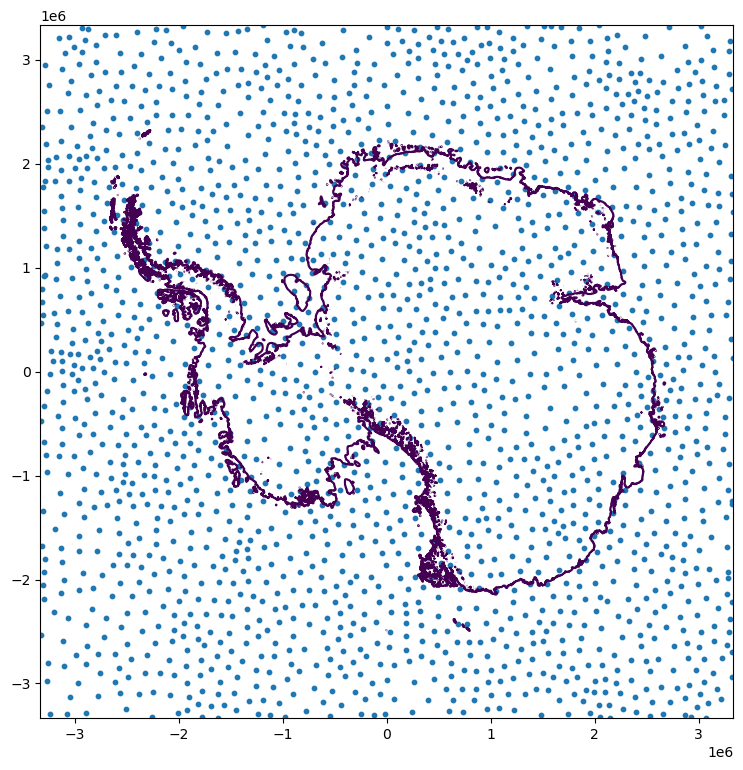

In [12]:
plt.figure(figsize=(9,9))
plt.scatter(points[:,0], points[:,1], s=10)
plt.contour(ds.x, ds.y, (ds.mask==1) | (ds.mask==4), levels=[0])
plt.axis('scaled')
plt.show()

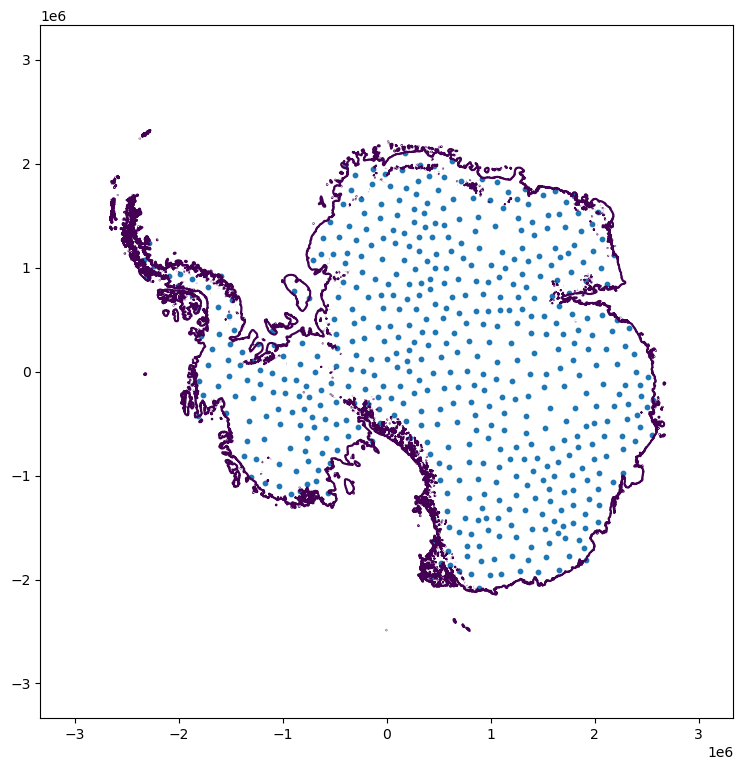

In [13]:
points_trim = points[good_points,:]
# inds = rng.integers(0, points_trim.shape[0]-1, 200)
# points_trim = points_trim[inds,:]
# print(points_trim.shape)

plt.figure(figsize=(9,9))
plt.contour(ds.x, ds.y, (ds.mask==1) | (ds.mask==4), levels=[0])
plt.scatter(points_trim[:,0], points_trim[:,1], s=10)
#plt.scatter(points_trim[55,0], points_trim[55,1], s=20, c='r')
plt.axis('scaled')
plt.show()

In [66]:
vel = xr.open_dataset(Path('D:/phase_vel/antarctic_ice_vel_phase_map_v01.nc'))
vel = vel.coarsen(x=10, y=10, boundary='trim').mean()
vel

<xarray.Dataset> Size: 87MB
Dimensions:       (y: 1244, x: 1244)
Coordinates:
  * x             (x) float64 10kB -2.798e+06 -2.793e+06 ... 2.791e+06 2.796e+06
  * y             (y) float64 10kB 2.798e+06 2.793e+06 ... -2.791e+06 -2.796e+06
    lat           (y, x) float64 12MB -54.7 -54.72 -54.75 ... -54.75 -54.73
    lon           (y, x) float64 12MB 315.0 315.0 315.1 ... 135.1 135.0 135.0
Data variables:
    coord_system  |S1 1B b''
    VX            (y, x) float32 6MB nan nan nan nan nan ... nan nan nan nan nan
    VY            (y, x) float32 6MB nan nan nan nan nan ... nan nan nan nan nan
    STDX          (y, x) float32 6MB nan nan nan nan nan ... nan nan nan nan nan
    STDY          (y, x) float32 6MB nan nan nan nan nan ... nan nan nan nan nan
    ERRX          (y, x) float32 6MB nan nan nan nan nan ... nan nan nan nan nan
    ERRY          (y, x) float32 6MB nan nan nan nan nan ... nan nan nan nan nan
    CNT           (y, x) float64 12MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SOURCE        (y, x) float64 12MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/27)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        v_mix.v8Jul2019.nc
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:            
    ...                        ...
    time_coverage_start:       1995-01-01
    time_coverage_end:         2016-12-31
    project:                   NASA/MEaSUREs
    creator_name:              J. Mouginot
    comment:                    
    license:                   No restrictions on access or use.

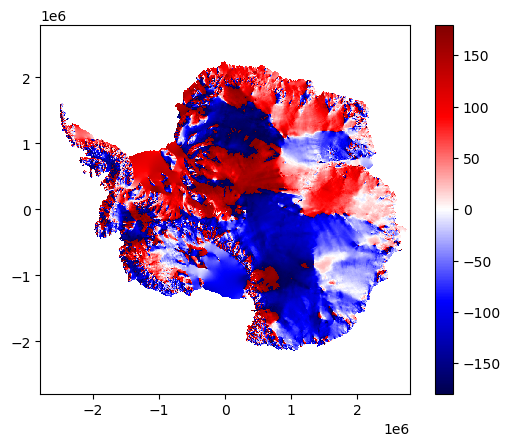

In [70]:
plt.pcolormesh(vel.x, vel.y, vel_angle, vmin=-180, vmax=180, cmap='seismic')
plt.axis('scaled')
plt.colorbar()
plt.show()

In [67]:
vel_angle = np.arctan2(vel.VY.values, vel.VX.values)*180/np.pi

In [68]:
%%time

xx_vel, yy_vel = np.meshgrid(vel.x, vel.y)

kn = vd.KNeighbors(k=1)
kn.fit((xx_vel, yy_vel), vel_angle)

CPU times: total: 547 ms
Wall time: 550 ms


KNeighbors()

In [64]:
size(kn)

NameError: name 'size' is not defined

In [59]:
azims = kn.predict((points_trim[:,0], points_trim[:,1]))

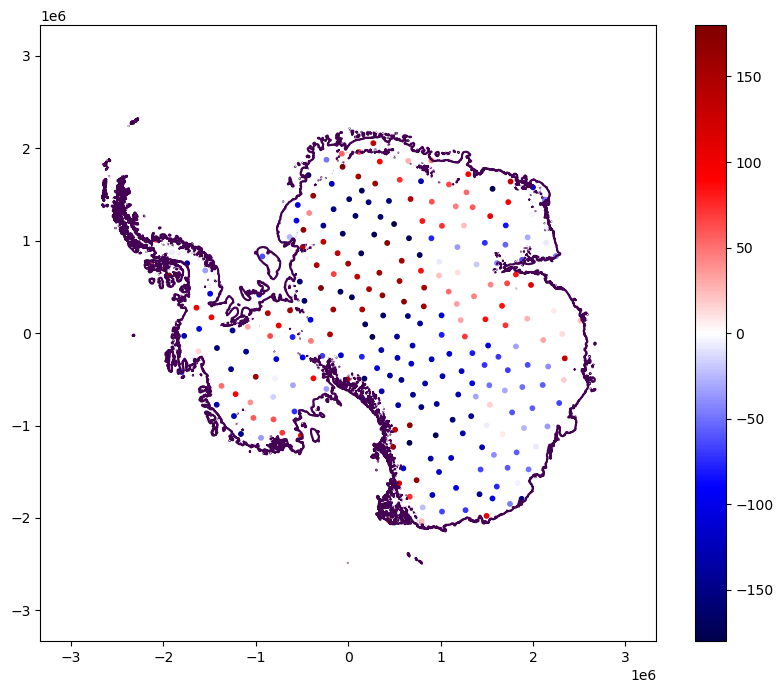

In [63]:
plt.figure(figsize=(10,8))
im = plt.scatter(points_trim[:,0], points_trim[:,1], c=azims, s=10, vmin=-180, vmax=180, cmap='seismic')
plt.contour(ds.x, ds.y, (ds.mask==1) | (ds.mask==4), levels=[0])
plt.axis('scaled')
plt.colorbar(im)
plt.show()

In [23]:
coordinates = (x_cond, y_cond)
values = norm_values

maxlag = 250e3
mindist = 200e3
dist_change = 50e3
mindata = 1000
directional=True

xi = points_trim[55,0]
yi = points_trim[55,1]

dist = mindist
n_cond = 0
while n_cond < mindata:
    dist_msk = vd.distance_mask((xi, yi), dist, coordinates)
    norm_near = values[dist_msk]
    n_cond = norm_near.size
    dist += dist_change

coords_near = np.array(coordinates).T[dist_msk,:]

inds = rng.integers(0, norm_near.shape[0]-1, mindata)
norm_near = norm_near[inds]
coords_near = coords_near[inds]

coords_near = coords_near[~np.isnan(norm_near)]
norm_near = norm_near[~np.isnan(norm_near)]

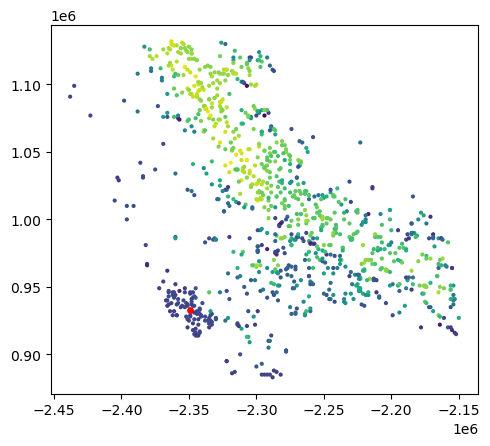

In [25]:
plt.scatter(coords_near[:,0], coords_near[:,1], c=norm_near, s=4)
plt.scatter(xi, yi, c='r', s=15)
plt.axis('scaled')
plt.show()

In [3]:
df = pd.read_csv('continent_variogram_params.csv')
df

,x,y,vars,range,sill,smooth,major_range,minor_range,azimuth
0,1.149617e+05,601577.944755,0.774564,71898.927149,0.816102,1.242904,60501.431941,59323.626630,-34.64036
1,-8.882338e+05,774443.841685,0.235228,140320.141924,0.298674,20.000000,138576.910159,194208.650683,-34.64036
2,-2.012069e+06,827438.984718,1.200058,62607.088488,1.247337,0.332931,64487.078923,58656.323759,-34.64036
3,2.558847e+06,-272667.265162,0.766948,250000.000000,0.961328,0.331564,250000.000000,250000.000000,-34.64036
4,-3.543205e+04,613132.924014,0.696045,94908.243955,0.659509,0.479933,59157.249282,119350.990477,-34.64036
...,...,...,...,...,...,...,...,...,...
522,-9.946976e+05,149956.861210,1.177335,134467.714457,1.216245,0.252337,39222.092877,250000.000000,-34.64036
523,-2.089874e+06,915860.485644,1.355716,53482.956136,1.399983,0.329337,43280.713893,94778.212426,-34.64036
524,3.089644e+05,-84124.095419,0.389400,56973.131584,0.399086,1.164561,102132.883668,49818.360903,-34.64036
525,1.844057e+06,399592.573646,0.440526,238998.936243,0.510534,0.237879,250000.000000,250000.000000,-34.64036


In [45]:
points = np.array([df.x.values, df.y.values]).T

In [46]:
def rbf_interp_msk(points, values, xx, yy, mask, smoothing):
    interp = RBFInterpolator(points, values, smoothing=smoothing)
    interp_vars = interp(np.array([xx[mask].flatten(), yy[mask].flatten()]).T)
    grid = np.full(xx.shape, np.nan)
    np.place(grid, mask, interp_vars)
    return grid

In [48]:
%%time

smoothing = 1e11

ice_rock_msk = (ds.mask == 1) | (ds.mask == 4) | (ds.mask == 2)

print('interpolating variance')
interp_vars = rbf_interp_msk(points, df.vars.values, xx, yy, ice_rock_msk, smoothing)

print('interpolating range')
interp_ranges = rbf_interp_msk(points, df.range.values, xx, yy, ice_rock_msk, smoothing)

print('interpolating sill')
interp_sills = rbf_interp_msk(points, df.sill.values, xx, yy, ice_rock_msk, smoothing)

print('interpolating smoothness')
interp_smooths = rbf_interp_msk(points, df.smooth.values, xx, yy, ice_rock_msk, smoothing)
interp_smooths = np.where(interp_smooths < 1.5, 1.5, interp_smooths)
interp_smooths = np.where(interp_smooths > 20, 20, interp_smooths)

print('interpolating major range')
interp_major_ranges = rbf_interp_msk(points, df.major_range.values, xx, yy, ice_rock_msk, smoothing)

print('interpolating minor range')
interp_minor_ranges = rbf_interp_msk(points, df.minor_range.values, xx, yy, ice_rock_msk, smoothing)

interpolating variance
interpolating range
interpolating sill
interpolating smoothness
interpolating major range
interpolating minor range
CPU times: total: 47min 53s
Wall time: 9min 38s


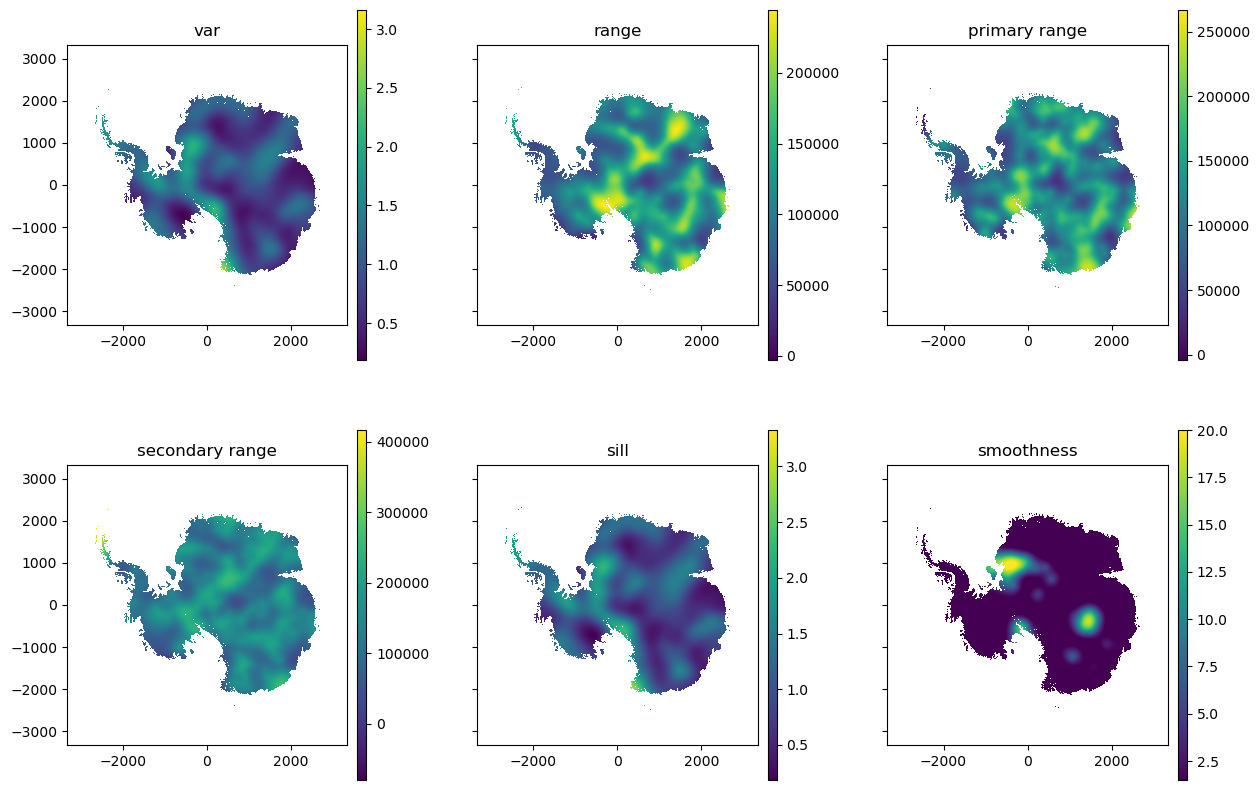

In [49]:
plots = [interp_vars, interp_ranges, interp_major_ranges, interp_minor_ranges, interp_sills, interp_smooths]
titles = ['var', 'range', 'primary range', 'secondary range', 'sill', 'smoothness']

fig, axs = plt.subplots(2, 3, figsize=(15,10), sharey=True)

for p, ax, title in zip(plots, axs.flatten(), titles):
    im = ax.pcolormesh(ds.x/1000, ds.y/1000, p)
    ax.axis('scaled')
    ax.set_title(title)
    plt.colorbar(im, ax=ax, pad=0.03, aspect=40)
plt.show()

# KNeighbors interpolation

In [94]:
def spline_interp_msk(points, values, xx, yy, mask, damping):
    sp = vd.Spline(damping=damping)
    sp.fit((points[:,0], points[:,1]), values)
    preds = sp.predict((xx[mask], yy[mask]))
    grid = np.full(xx.shape, np.nan)
    np.place(grid, mask, preds)
    return grid

In [95]:
%%time

damping = 1e-5
maxlag = 250e3

print('interpolating variance')
interp_vars = spline_interp_msk(points, df.vars.values, xx, yy, ice_rock_msk, damping)

print('interpolating range')
interp_ranges = spline_interp_msk(points, df.range.values, xx, yy, ice_rock_msk, damping)
interp_ranges = np.where(interp_ranges < 0, np.mean(interp_ranges), interp_ranges)
interp_ranges = np.where(interp_ranges > maxlag, maxlag, interp_ranges)

print('interpolating sill')
interp_sills = spline_interp_msk(points, df.sill.values, xx, yy, ice_rock_msk, damping)

print('interpolating smoothness')
interp_smooths = spline_interp_msk(points, df.smooth.values, xx, yy, ice_rock_msk, damping)
interp_smooths = np.where(interp_smooths < 1.5, 1.5, interp_smooths)
interp_smooths = np.where(interp_smooths > 20, 20, interp_smooths)

print('interpolating major range')
interp_major_ranges = spline_interp_msk(points, df.major_range.values, xx, yy, ice_rock_msk, damping)
interp_major_ranges = np.where(interp_major_ranges < 0, np.mean(interp_major_ranges), interp_major_ranges)
interp_major_ranges = np.where(interp_major_ranges > maxlag, maxlag, interp_major_ranges)

print('interpolating minor range')
interp_minor_ranges = spline_interp_msk(points, df.minor_range.values, xx, yy, ice_rock_msk, k)
interp_minor_ranges = np.where(interp_minor_ranges < 0, np.mean(interp_minor_ranges), interp_minor_ranges)
interp_minor_ranges = np.where(interp_minor_ranges > maxlag, maxlag, interp_minor_ranges)

interpolating variance
interpolating range
interpolating sill
interpolating smoothness
interpolating major range
interpolating minor range
CPU times: total: 11min 13s
Wall time: 45.7 s


In [96]:
dsv = xr.Dataset(
    data_vars=dict(
        varr=(('y', 'x'), interp_vars),
        ranges=(('y', 'x'), interp_ranges),
        sill=(('y', 'x'), interp_sills),
        smooth=(('y', 'x'), interp_smooths),
        major_range=(('y', 'x'), interp_major_ranges),
        minor_range=(('y', 'x'), interp_minor_ranges)
    ),
    coords=dict(
        y=('y', ds.y.values),
        x=('x', ds.x.values)
    )
)
dsv_trim = dsv.coarsen(x=10, y=10, boundary='trim').mean()
dsv_trim

<xarray.Dataset> Size: 21MB
Dimensions:      (y: 666, x: 666)
Coordinates:
  * y            (y) float32 3kB 3.328e+06 3.318e+06 ... -3.312e+06 -3.322e+06
  * x            (x) float32 3kB -3.328e+06 -3.318e+06 ... 3.312e+06 3.322e+06
Data variables:
    varr         (y, x) float64 4MB nan nan nan nan nan ... nan nan nan nan nan
    ranges       (y, x) float64 4MB nan nan nan nan nan ... nan nan nan nan nan
    sill         (y, x) float64 4MB nan nan nan nan nan ... nan nan nan nan nan
    smooth       (y, x) float64 4MB nan nan nan nan nan ... nan nan nan nan nan
    major_range  (y, x) float64 4MB nan nan nan nan nan ... nan nan nan nan nan
    minor_range  (y, x) float64 4MB nan nan nan nan nan ... nan nan nan nan nan

In [98]:
dsv = xr.open_dataset(Path('scripts/continental_variogram.nc'))

dsv_trim = dsv.coarsen(x=10, y=10, boundary='trim').mean()
dsv_trim

<xarray.Dataset> Size: 21MB
Dimensions:      (y: 666, x: 666)
Coordinates:
  * y            (y) float32 3kB 3.328e+06 3.318e+06 ... -3.312e+06 -3.322e+06
  * x            (x) float32 3kB -3.328e+06 -3.318e+06 ... 3.312e+06 3.322e+06
Data variables:
    varr         (y, x) float64 4MB nan nan nan nan nan ... nan nan nan nan nan
    ranges       (y, x) float64 4MB nan nan nan nan nan ... nan nan nan nan nan
    sill         (y, x) float64 4MB nan nan nan nan nan ... nan nan nan nan nan
    smooth       (y, x) float64 4MB nan nan nan nan nan ... nan nan nan nan nan
    major_range  (y, x) float64 4MB nan nan nan nan nan ... nan nan nan nan nan
    minor_range  (y, x) float64 4MB nan nan nan nan nan ... nan nan nan nan nan

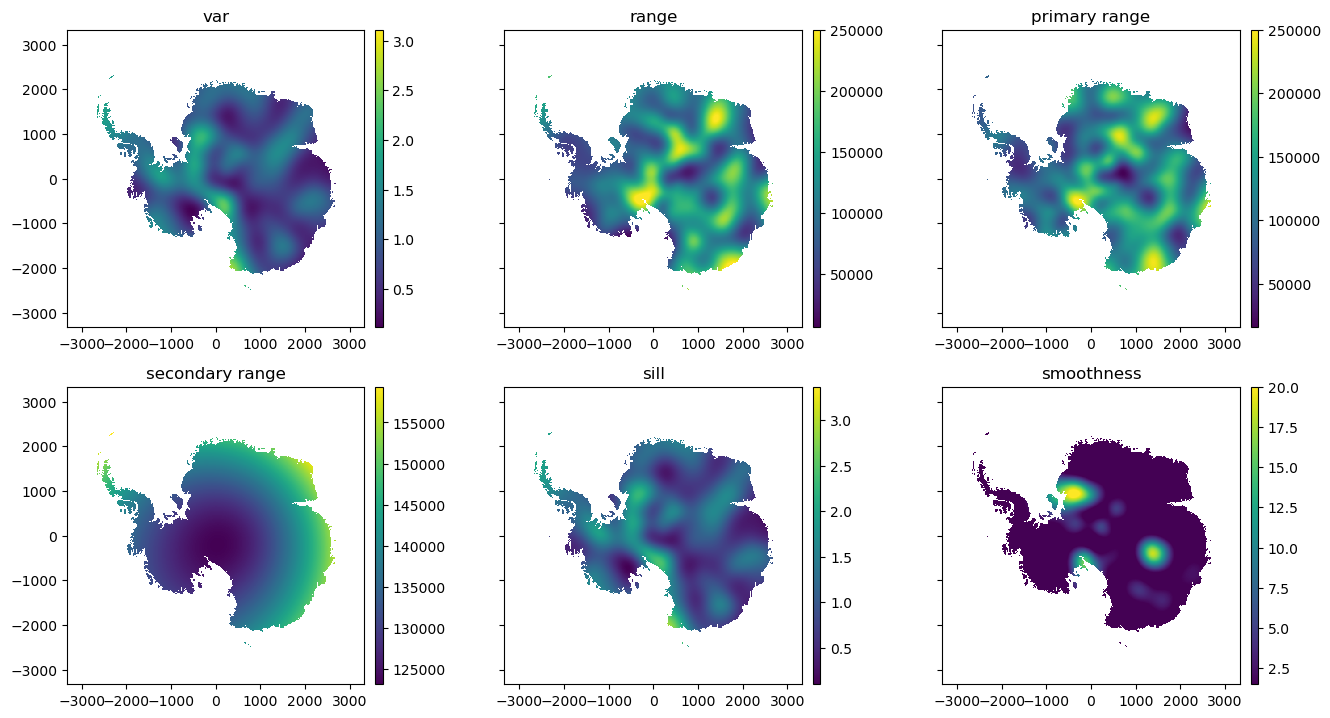

In [99]:
plots = [dsv_trim.varr.values, dsv_trim.ranges.values, dsv_trim.major_range.values, dsv_trim.minor_range.values, dsv_trim.sill.values, dsv_trim.smooth.values]
titles = ['var', 'range', 'primary range', 'secondary range', 'sill', 'smoothness']

fig, axs = plt.subplots(2, 3, figsize=(16,8.5), sharey=True)

for p, ax, title in zip(plots, axs.flatten(), titles):
    im = ax.pcolormesh(dsv_trim.x/1000, dsv_trim.y/1000, p)
    ax.axis('scaled')
    ax.set_title(title)
    plt.colorbar(im, ax=ax, pad=0.03, aspect=40)
plt.show()